## Import packages

In [166]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Initialization

Use He initialization: [He et al., 2015. Delving Deep into Rectifiers: Surpassing Human-Level Performance in ImageNet Classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf). Initializes weights $W$ as random Normal variables with variance $\frac{2}{\sqrt{n^{L-1}}}$.

In [25]:
def initialize_parameters(layer_dims):
    """
    Initializes the neural network parameters.
    
    Args:
    layer_dims: A list of the dimensions of every layer.
    
    Returns:
    parameters: A dict object containing keys, "W1", "b1", etc.
                Each Wi has dimensions (layer_dims[l], layer_dims[l-1])
                Each bi has dimensions (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)
    
    for i in range(1, L):
        # Use He initialization: 
        # He et al., 2015. Delving Deep into Rectifiers: Surpassing Human-Level Performance in 
        # ImageNet Classification.
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2 / layer_dims[i-1])
        parameters['b' + str(i)] = np.zeros((layer_dims[i], 1))
    
    return parameters

## Forward propagation

Two activations are implemented:  
* Sigmoid: $\frac{1}{1 + e^{-z}}$
* ReLU: $max(0, z)$

The forward prop can be thought of as each layer computing $W^T X + b$, and applying an activation on the resulting vector.

In [16]:
def sigmoid(z):
    """
    Returns the sigmoid of the vector z
    
    Args:
    z: The vector to take sigmoid of
    
    Returns: The softmax of the values and the cache, z
    """
    sigmoid = 1 / (1 + np.exp(-z))
    return (sigmoid, z)

In [56]:
def relu(z):
    """
    Returns a ReLu activation of the vector z
    
    Args:
    z: The vector to take relu of
    
    Returns:
    a: The ReLu of z
    cache: The value z
    """
    out = np.maximum(z, 0)
    return out, z

In [109]:
def linear_forward(A, W, b):
    """
    Implement the first part of a layer, i.e., computing the weighted sums.
    
    Args:
    A: Activations from the previous layer
    W: Weight matrix for this layer
    b: Bias vector for this layer
    
    Returns:
    Z: The weighted sum vector
    cache: A tuple containing "A", "W", and "b" for use in backward prop
    """
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [14]:
def single_layer_forward(A_prev, W, b, activation):
    """
    Implements a single layer's forward prop, with activation.
    
    Args:
    A_prev: Activations from the previous layer
    W: The weight matrix of the current layer
    b: The bias vector for the current layer
    activation: A string, 'relu' or 'sigmoid'
    
    Returns:
    A: The outputs of the current layer's activations
    cache: A tuple containing 'linear_cache' and 'activation_cache'
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    return A, cache

In [175]:
def forward_propagate(X, parameters, activations):
    """
    Implements forward propagation.
    
    Args:
    X: The inputs
    parameters: The parameters initialized
    activations: The activations to apply at each layer
    
    Returns:
    AL: The final outputs
    caches: A dict with the caches from each layer
    """
    A = X
    caches = []
    L = len(parameters) // 2
    
    for i in range(1, L):
        A_prev = A
        
        A, cache = single_layer_forward(A_prev, 
                                        W=parameters['W' + str(i)], 
                                        b=parameters['b' + str(i)],
                                        activation=activations[i-1])
        caches.append(cache)
    
    AL, cache = single_layer_forward(A, 
                                     W=parameters['W' + str(L)], 
                                     b=parameters['b' + str(L)], 
                                     activation='sigmoid')
    caches.append(cache)
    return AL, caches

## Cost function

The cross-entropy cost function is $-\frac{1}{m} \sum \limits_{i=1}^m \left( y^{(i)}\log a^{[L](i)} + (1 - y^{(i)})\log (1 - a^{[L](i)}) \right)$

In [155]:
def compute_cost(AL, Y):
    """
    Computes the cross-entropy loss
    
    Args:
    AL: Sigmoid output of the network
    Y: True outputs
    
    Returns:
    cost: The current cost
    """
    m = max(*Y.shape)
    Y = Y.reshape(1, m)
    
    cost = (-1. / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))
    cost = np.squeeze(cost)
    
    return cost

## Backward prop

For the linear part, the formulas are:  

$Z^{[l]} = W^{[l]T} A^{[l-1]} + b^{[l]}$  

1. **Weight matrix:**   
$\frac{\mathrm{d}L}{\mathrm{d}W^{[l]}} = \frac{1}{m} \frac{\mathrm{d}L}{\mathrm{d}Z^{[l]}}A^{[l-1]T}$

2. **Bias term:**  
$\frac{\mathrm{d}L}{\mathrm{d}b^{[l]}} = \frac{1}{m} \sum \limits_{i=1}^m \frac{\mathrm{d}L}{\mathrm{d}Z^{[l](i)}}$

3. **Previous layer activation:**  
$\frac{\mathrm{d}L}{\mathrm{d}A^{[l-1]}} = W^{[l]T} \frac{\mathrm{d}L}{\mathrm{d}Z^{[l]}}$

In [157]:
def linear_backward(dZ, cache):
    """
    Implements the linear part of the backward propagation for one layer
    
    Args:
    dZ: The derivative of the cost wrt linear output of current layer
    cache: The cache from the forward propagation
    
    Returns:
    dA_prev: Derivative of cost wrt A[l-1]
    dW: Derivative of cost wrt W[l]
    db: Derivative of cost wrt b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

Next, implement the backward prop for the whole layer including the activation.  
$A^{[l]} = g(Z^{[l]})$  
$dZ^{[l]} = dA^{[l]} \times g^{\prime}(Z^{[l]})$ (why?)

In [151]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    
    Args:
    dA: Post-activation gradient
    cache: "Z" stored for computing gradient
    
    Returns:
    dZ: Gradient of the cost wrt z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    return dZ

In [152]:
def single_backward(dA, cache, activation):
    """
    Implements the backward pass for one complete layer, including activations.
    
    Args:
    dA: Gradient of activation of the current layer
    cache: Tuple (linear_cache, activation_cache) from forward pass
    activation: The activation at the current layer
    
    Returns:
    dA_prev: Gradient of loss wrt A[l-1]
    dW: Gradient of loss wrt W[l]
    db: Gradient of loss wrt b[l]
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = dA * sigmoid(activation_cache)[0] * (1 - sigmoid(activation_cache)[0])
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [158]:
def backward_prop(AL, Y, caches, activations):
    """
    Implements backward propagation.
    
    Args:
    AL: The output of the network
    Y: The true output
    caches: The caches collected during forward prop
    
    Returns:
    grads: A dict with gradients grads['dW1'], grads['dA1'], grads['db1'], etc.
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(Y / AL - (1 - Y) / (1 - AL))
    
    cache = caches[-1]
    grads['dA' + str(L)], grads['dW' + str(L)], grads['db' + str(L)] = single_backward(dAL, cache, activations[-1])

    for i in reversed(range(L-1)):
        cache = caches[i]
        
        dA_prev, dW, db = single_backward(grads['dA' + str(i+2)], cache, activations[i])
        
        grads['dA' + str(i+1)] = dA_prev
        grads['dW' + str(i+1)] = dW
        grads['db' + str(i+1)] = db
    return grads

## Update Parameters

In [118]:
def update_parameters(params, grads, learning_rate):
    """
    Updates parameters using gradient descent
    
    Args:
    params: The current parameters of the model
    grads: The gradients from backward pass
    learning_rate: The learning rate for GD
    
    Returns:
    parameters: Parameters after gradient descent
    """
    L = len(parameters) // 2
    
    for i in range(L):
        parameters['W' + str(i+1)] -= learning_rate * grads['dW' + str(i+1)]
        parameters['b' + str(i+1)] -= learning_rate * grads['db' + str(i+1)]
    
    return parameters

## The full model

In [170]:
parameters = initialize_parameters([2, 2, 1])

In [171]:
grads = {}
costs = []
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
Y = np.array([0, 1, 1, 0]).reshape(4, 1)
m = X.shape[1]
n_x, n_h, n_y = (2, 2, 1)

In [172]:
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']

In [173]:
for i in range(1000):
    A3, caches = forward_propagate(X, parameters, ['relu', 'relu', 'sigmoid'])
    cost = compute_cost(A3, Y)
    grads = backward_prop(A3, Y, caches, ['relu', 'relu', 'sigmoid'])
    parameters = update_parameters(parameters, grads, 0.01)
    costs.append(cost)

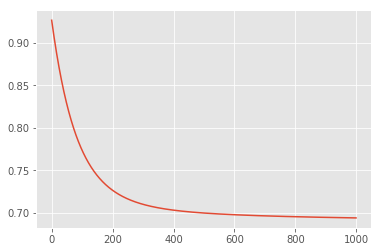

In [174]:
plt.plot(costs);